In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import config
import numpy as np
import os

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)
    


# Load the pre-trained Generator model
model = Generator()
checkpoint = torch.load("gen.pth", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])
model.to("cuda")
model.eval()

img_height = 224
img_width =  224
# Download a random image from the internet
url = f'https://picsum.photos/{img_width}/{img_height}'
#url = f'https://thumbs.dreamstime.com/b/elegant-water-dog-tuxedo-sitting-chair-celebration-concept-312175594.jpg?w=768/{img_width}/{img_height}'
#url = f'https://th.bing.com/th/id/R.8a2c5c9d7c2c4c6dc91e2056d9c5525d?rik=43Z94ziaVmR8tw&riu=http%3a%2f%2fpeople.csail.mit.edu%2fbillf%2fproject+pages%2fsresCode%2fMarkov+Random+Fields+for+Super-Resolution_files%2f113044_lowres.jpg&ehk=9F%2fmB68hhi01g1wa5tuK8%2fEvoB4mgiKKOmZoIRqVtxo%3d&risl=&pid=ImgRaw&r=0/{img_width}/{img_height}'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#img = Image.open("test_images/baboon_LR.png").convert("RGB")

# Apply the test transform to the input image
input_image = config.test_transform(image=np.asarray(img))["image"].unsqueeze(0).to("cuda")
print(input_image.shape[2],input_image.shape[3])
img_height = input_image.shape[2]
img_width =  input_image.shape[3]
# Generate the super-resolution image
with torch.no_grad():
    upscaled_img = model(input_image)

# Convert the upscaled image tensor to a PIL image
upscaled_img = upscaled_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
upscaled_img = (upscaled_img * 255.0).clip(0, 255).astype('uint8')
upscaled_img = Image.fromarray(upscaled_img)

# Perform 4x bicubic upscaling for comparison
bicubic_upscale = transforms.Resize((img_height * 4, img_width * 4), interpolation=Image.BICUBIC)(img)

# Plot the original image, super-resolution image, and bicubic upscaling
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(upscaled_img)
axs[1].set_title('Super-Resolution Image')
axs[2].imshow(bicubic_upscale)
axs[2].set_title('4x Bicubic Upscaling')

plt.tight_layout()
plt.show()


# Create the test folder if it doesn't exist
test_folder = "test_1"
if os.path.exists(test_folder):
    test_folder = "test_2"
os.makedirs(test_folder, exist_ok=True)

# Save the images in the test folder
img.save(os.path.join(test_folder, "original_image.png"))
upscaled_img.save(os.path.join(test_folder, "super_resolution_image.png"))
bicubic_upscale.save(os.path.join(test_folder, "bicubic_upscale_image.png"))

print(f"Images saved in the '{test_folder}' folder.")

In [ ]:
import os
import cv2

video_path = "./Video/lowRes/speech.mp4"

# Open the video file
video = cv2.VideoCapture(video_path)

# Get the video properties
fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set the output video path
output_path = "./Video/HighRes/speech.mp4"

# Create a VideoWriter object for saving the output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
output_video = cv2.VideoWriter(output_path, fourcc, fps, (width * 4, height * 4))

# Process the video frame by frame
while True:
    ret, frame = video.read()
    if not ret:
        break

    # Convert the frame from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert the frame to a PIL image
    img = Image.fromarray(frame)

    # Apply the test transform to the input frame
    input_frame = config.test_transform(image=np.asarray(img))["image"].unsqueeze(0).to("cuda")

    # Generate the super-resolution frame
    with torch.no_grad():
        upscaled_frame = model(input_frame)

    # Convert the upscaled frame tensor to a numpy array
    upscaled_frame = upscaled_frame.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    upscaled_frame = (upscaled_frame * 255.0).clip(0, 255).astype('uint8')

    # Convert the upscaled frame from RGB to BGR
    upscaled_frame = cv2.cvtColor(upscaled_frame, cv2.COLOR_RGB2BGR)

    # Write the upscaled frame to the output video
    output_video.write(upscaled_frame)

# Release the video objects
video.release()
output_video.release()

print(f"Upscaled video saved as '{output_path}'.")

Files already downloaded and verified
Epoch [1/10], Loss: 1.3294, Accuracy: 52.22%
Epoch [2/10], Loss: 0.8872, Accuracy: 68.76%
Epoch [3/10], Loss: 0.5993, Accuracy: 79.05%
Epoch [4/10], Loss: 0.3041, Accuracy: 89.34%
Epoch [5/10], Loss: 0.1250, Accuracy: 95.73%
Epoch [6/10], Loss: 0.0780, Accuracy: 97.34%
Epoch [7/10], Loss: 0.0735, Accuracy: 97.50%
Epoch [8/10], Loss: 0.0573, Accuracy: 98.08%
Epoch [9/10], Loss: 0.0568, Accuracy: 98.16%
Epoch [10/10], Loss: 0.0463, Accuracy: 98.48%


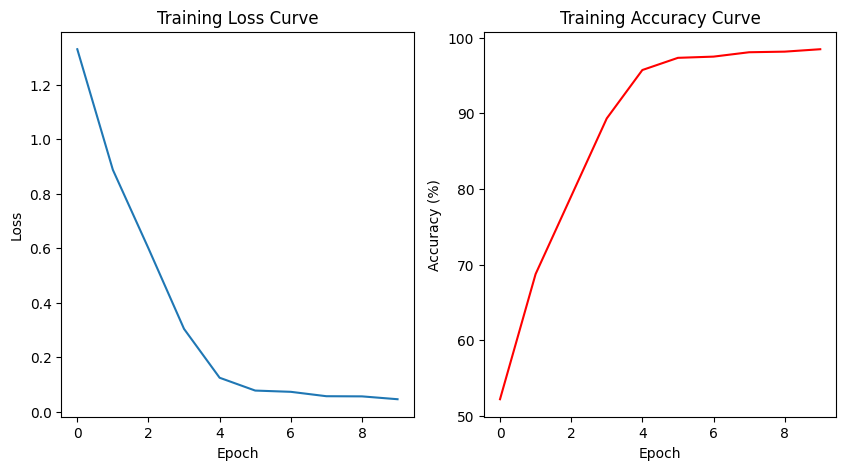

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Initialize the model
model = SimpleCNN()

# Move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))

    return train_losses, train_accs

# Train the model
train_losses, train_accs = train_model(model, criterion, optimizer, num_epochs=10)

# Plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')

plt.show()


In [13]:
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import config
import numpy as np
import os
import csv

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x



class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)
    


# Load the pre-trained Generator model
esrgan = Generator()
checkpoint = torch.load("gen.pth", map_location="cuda")
esrgan.load_state_dict(checkpoint["state_dict"])
esrgan.to("cuda")
esrgan.eval()


# Load the CIFAR10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

# Define function to upscale images using the Generator
def upscale_image(image, model):
    with torch.no_grad():
        upscaled_image = model(image)
    return upscaled_image

# Upscale and save the test set images
output_folder = "upscaled_cifar10_test"
os.makedirs(output_folder, exist_ok=True)

# CSV file to save labels
csv_filename = os.path.join(output_folder, "labels.csv")
with open(csv_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Label"])

    # Initialize progress bar with tqdm
    for i, (image, label) in enumerate(tqdm(test_loader, desc="Upscaling images")):
        image = image.to("cuda")
        upscaled_image = upscale_image(image, esrgan).cpu()

        # Save the upscaled image
        filename = f"image_{i}.png"
        upscaled_image_path = os.path.join(output_folder, filename)
        torchvision.utils.save_image(upscaled_image, upscaled_image_path)
        
        # Write the filename and label to the CSV file
        writer.writerow([filename, label.item()])

print(f"Upscaled images and labels saved in the '{output_folder}' folder.")

Files already downloaded and verified


Upscaling images: 100%|██████████| 10000/10000 [22:16<00:00,  7.48it/s]

Upscaled images and labels saved in the 'upscaled_cifar10_test' folder.


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class UpscaledCIFAR10Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_labels.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.image_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations if needed (e.g., for normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the dataset
dataset = UpscaledCIFAR10Dataset(csv_file='upscaled_cifar10_test/labels.csv',
                                 root_dir='upscaled_cifar10_test',
                                 transform=transform)
# Define the DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)




In [9]:
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for i,(images, labels) in enumerate(tqdm(data_loader, desc="classifying images")):
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [14]:
from tqdm import tqdm

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True)

accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the model on the  CIFAR-10 test images: {accuracy:.2f}%')

classifying images: 100%|██████████| 313/313 [00:07<00:00, 43.33it/s]

Accuracy of the model on the  CIFAR-10 test images: 61.75%


In [15]:

# Calculate accuracy
accuracy = evaluate_model(model, data_loader)
print(f'Accuracy of the model on the upscaled CIFAR-10 test images: {accuracy:.2f}%')


classifying images: 100%|██████████| 313/313 [00:13<00:00, 22.36it/s]

Accuracy of the model on the upscaled CIFAR-10 test images: 57.62%
